In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

os = posix
folder: /tf/notebooks/data/0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [18]:
image_size=[100,100]
heatmap_size=[29,29]

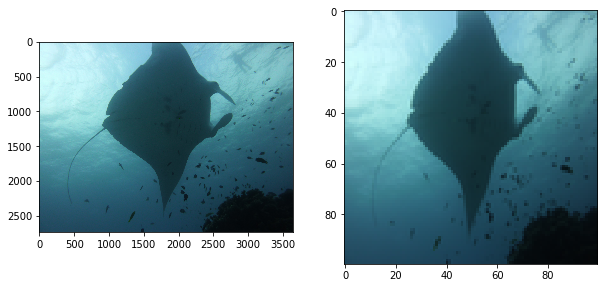

In [19]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


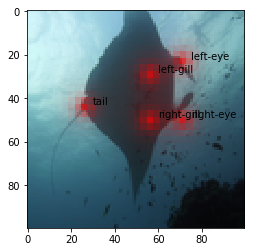

In [8]:
mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)

In [55]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=heatmaps[::-1,:,]
    le=flip_heatmap
    ,re,lg,rg,t=heatmaps[::-1,:,]
    return flip_image,flip_heatmap

In [31]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    if image.shape[2]>3:
        image=image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    #if image.shape[2]>3:
    #    image=image[:,:,:3]
        #print("\n More then 3 channels")
        #print(blm_path)
        #numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,:2])
        X.append(image) 
        #flip_img, flip_hm=flip_image(image,numpy_heatmaps)
        #y.append(flip_hm[:,:,:2])
        #X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57  
 Error on /tf/notebooks/data/0_manta_selected_annotated_some/0012 Laverna/12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json
58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244

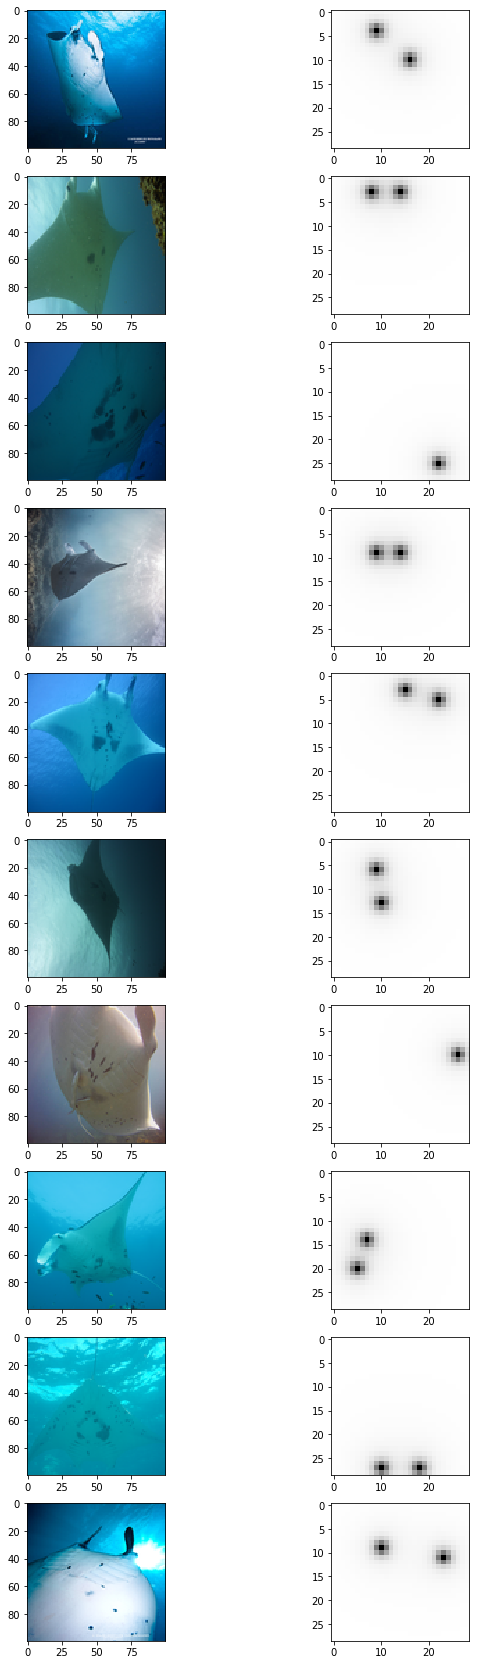

In [32]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s].sum(axis=2),cmap='Greys')
plt.show()

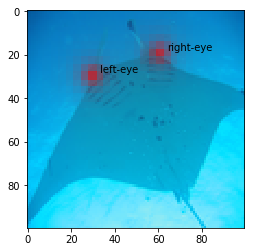

In [34]:
i=17
mfp.apply_heatmaps(mfp.denormalize(X[i]),y[i])
    

In [35]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [36]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [37]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [38]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [39]:
model=Sequential()
#model.add(vgg16_net)
model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=2,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 6, 6, 512)         14714688  
_________________________________________________________________
batch_normalization_v1_13 (B (None, 6, 6, 512)         2048      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 13, 13, 256)       1179904   
_________________________________________________________________
batch_normalization_v1_14 (B (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 27, 27, 64)        147520    
_________________________________________________________________
batch_normalization_v1_15 (B (None, 27, 27, 64)        256       
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 29, 29, 2)         1154      
__________

In [40]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [41]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=500,validation_split=0.1)

training_time=round(time.time() - start_time,2)

Train on 252 samples, validate on 28 samples
Epoch 1/500
252/252 [==============================] - 7s 28ms/sample - loss: 23.8588 - binary_accuracy: 0.0680 - val_loss: 103.7944 - val_binary_accuracy: 0.0197
Epoch 2/500
252/252 [==============================] - 2s 8ms/sample - loss: 23.0617 - binary_accuracy: 0.0709 - val_loss: 91.4849 - val_binary_accuracy: 0.0225
Epoch 3/500
252/252 [==============================] - 2s 8ms/sample - loss: 22.7693 - binary_accuracy: 0.0684 - val_loss: 29.9251 - val_binary_accuracy: 0.0266
Epoch 4/500
252/252 [==============================] - 2s 8ms/sample - loss: 22.8406 - binary_accuracy: 0.0767 - val_loss: 26.0732 - val_binary_accuracy: 0.0293
Epoch 5/500
252/252 [==============================] - 2s 8ms/sample - loss: 22.0637 - binary_accuracy: 0.0704 - val_loss: 21.1331 - val_binary_accuracy: 0.0318
Epoch 6/500
252/252 [==============================] - 2s 8ms/sample - loss: 21.4953 - binary_accuracy: 0.0653 - val_loss: 19.0503 - val_binary_accu

252/252 [==============================] - 2s 8ms/sample - loss: 16.5487 - binary_accuracy: 0.0873 - val_loss: 14.4593 - val_binary_accuracy: 0.0357
Epoch 52/500
252/252 [==============================] - 2s 8ms/sample - loss: 16.4597 - binary_accuracy: 0.0873 - val_loss: 14.3889 - val_binary_accuracy: 0.0357
Epoch 53/500
252/252 [==============================] - 2s 8ms/sample - loss: 16.3718 - binary_accuracy: 0.0873 - val_loss: 14.3186 - val_binary_accuracy: 0.0357
Epoch 54/500
252/252 [==============================] - 2s 8ms/sample - loss: 16.2841 - binary_accuracy: 0.0873 - val_loss: 14.2486 - val_binary_accuracy: 0.0357
Epoch 55/500
252/252 [==============================] - 2s 8ms/sample - loss: 16.1975 - binary_accuracy: 0.0873 - val_loss: 14.1788 - val_binary_accuracy: 0.0357
Epoch 56/500
252/252 [==============================] - 2s 8ms/sample - loss: 16.1112 - binary_accuracy: 0.0873 - val_loss: 14.1092 - val_binary_accuracy: 0.0357
Epoch 57/500
252/252 [===================

252/252 [==============================] - 2s 8ms/sample - loss: 12.7767 - binary_accuracy: 0.0873 - val_loss: 11.2905 - val_binary_accuracy: 0.0357
Epoch 102/500
252/252 [==============================] - 2s 8ms/sample - loss: 12.7132 - binary_accuracy: 0.0873 - val_loss: 11.2356 - val_binary_accuracy: 0.0357
Epoch 103/500
252/252 [==============================] - 2s 8ms/sample - loss: 12.6508 - binary_accuracy: 0.0873 - val_loss: 11.1810 - val_binary_accuracy: 0.0357
Epoch 104/500
252/252 [==============================] - 2s 8ms/sample - loss: 12.5879 - binary_accuracy: 0.0873 - val_loss: 11.1268 - val_binary_accuracy: 0.0357
Epoch 105/500
252/252 [==============================] - 2s 8ms/sample - loss: 12.5258 - binary_accuracy: 0.0873 - val_loss: 11.0729 - val_binary_accuracy: 0.0357
Epoch 106/500
252/252 [==============================] - 2s 8ms/sample - loss: 12.4645 - binary_accuracy: 0.0873 - val_loss: 11.0193 - val_binary_accuracy: 0.0357
Epoch 107/500
252/252 [=============

252/252 [==============================] - 2s 8ms/sample - loss: 10.0838 - binary_accuracy: 0.0873 - val_loss: 8.9288 - val_binary_accuracy: 0.0357
Epoch 152/500
252/252 [==============================] - 2s 8ms/sample - loss: 10.0385 - binary_accuracy: 0.0873 - val_loss: 8.8888 - val_binary_accuracy: 0.0357
Epoch 153/500
252/252 [==============================] - 2s 8ms/sample - loss: 9.9944 - binary_accuracy: 0.0873 - val_loss: 8.8492 - val_binary_accuracy: 0.0357
Epoch 154/500
252/252 [==============================] - 2s 8ms/sample - loss: 9.9493 - binary_accuracy: 0.0873 - val_loss: 8.8098 - val_binary_accuracy: 0.0357
Epoch 155/500
252/252 [==============================] - 2s 8ms/sample - loss: 9.9043 - binary_accuracy: 0.0873 - val_loss: 8.7706 - val_binary_accuracy: 0.0357
Epoch 156/500
252/252 [==============================] - 2s 8ms/sample - loss: 9.8605 - binary_accuracy: 0.0873 - val_loss: 8.7318 - val_binary_accuracy: 0.0357
Epoch 157/500
252/252 [=======================

Epoch 202/500
252/252 [==============================] - 2s 8ms/sample - loss: 8.1144 - binary_accuracy: 0.0873 - val_loss: 7.1897 - val_binary_accuracy: 0.0357
Epoch 203/500
252/252 [==============================] - 2s 8ms/sample - loss: 8.0816 - binary_accuracy: 0.0873 - val_loss: 7.1610 - val_binary_accuracy: 0.0357
Epoch 204/500
252/252 [==============================] - 2s 8ms/sample - loss: 8.0507 - binary_accuracy: 0.0873 - val_loss: 7.1325 - val_binary_accuracy: 0.0357
Epoch 205/500
252/252 [==============================] - 2s 8ms/sample - loss: 8.0169 - binary_accuracy: 0.0873 - val_loss: 7.1041 - val_binary_accuracy: 0.0357
Epoch 206/500
252/252 [==============================] - 2s 8ms/sample - loss: 7.9860 - binary_accuracy: 0.0873 - val_loss: 7.0759 - val_binary_accuracy: 0.0357
Epoch 207/500
252/252 [==============================] - 2s 8ms/sample - loss: 7.9545 - binary_accuracy: 0.0873 - val_loss: 7.0479 - val_binary_accuracy: 0.0357
Epoch 208/500
252/252 [===========

Epoch 253/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.6904 - binary_accuracy: 0.0873 - val_loss: 5.9319 - val_binary_accuracy: 0.0357
Epoch 254/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.6674 - binary_accuracy: 0.0873 - val_loss: 5.9110 - val_binary_accuracy: 0.0357
Epoch 255/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.6437 - binary_accuracy: 0.0873 - val_loss: 5.8902 - val_binary_accuracy: 0.0357
Epoch 256/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.6196 - binary_accuracy: 0.0873 - val_loss: 5.8695 - val_binary_accuracy: 0.0357
Epoch 257/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.5958 - binary_accuracy: 0.0873 - val_loss: 5.8490 - val_binary_accuracy: 0.0357
Epoch 258/500
252/252 [==============================] - 2s 8ms/sample - loss: 6.5735 - binary_accuracy: 0.0873 - val_loss: 5.8286 - val_binary_accuracy: 0.0357
Epoch 259/500
252/252 [===========

Epoch 304/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.6464 - binary_accuracy: 0.0873 - val_loss: 5.0105 - val_binary_accuracy: 0.0357
Epoch 305/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.6296 - binary_accuracy: 0.0873 - val_loss: 4.9951 - val_binary_accuracy: 0.0357
Epoch 306/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.6130 - binary_accuracy: 0.0873 - val_loss: 4.9798 - val_binary_accuracy: 0.0357
Epoch 307/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.5946 - binary_accuracy: 0.0873 - val_loss: 4.9645 - val_binary_accuracy: 0.0357
Epoch 308/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.5772 - binary_accuracy: 0.0873 - val_loss: 4.9494 - val_binary_accuracy: 0.0357
Epoch 309/500
252/252 [==============================] - 2s 8ms/sample - loss: 5.5615 - binary_accuracy: 0.0873 - val_loss: 4.9343 - val_binary_accuracy: 0.0357
Epoch 310/500
252/252 [===========

Epoch 355/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8741 - binary_accuracy: 0.0873 - val_loss: 4.3275 - val_binary_accuracy: 0.0357
Epoch 356/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8617 - binary_accuracy: 0.0873 - val_loss: 4.3161 - val_binary_accuracy: 0.0357
Epoch 357/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8475 - binary_accuracy: 0.0873 - val_loss: 4.3046 - val_binary_accuracy: 0.0357
Epoch 358/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8353 - binary_accuracy: 0.0873 - val_loss: 4.2933 - val_binary_accuracy: 0.0357
Epoch 359/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8214 - binary_accuracy: 0.0873 - val_loss: 4.2820 - val_binary_accuracy: 0.0357
Epoch 360/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.8096 - binary_accuracy: 0.0873 - val_loss: 4.2707 - val_binary_accuracy: 0.0357
Epoch 361/500
252/252 [===========

Epoch 406/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2945 - binary_accuracy: 0.0873 - val_loss: 3.8164 - val_binary_accuracy: 0.0357
Epoch 407/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2844 - binary_accuracy: 0.0873 - val_loss: 3.8077 - val_binary_accuracy: 0.0357
Epoch 408/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2747 - binary_accuracy: 0.0873 - val_loss: 3.7991 - val_binary_accuracy: 0.0357
Epoch 409/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2647 - binary_accuracy: 0.0873 - val_loss: 3.7906 - val_binary_accuracy: 0.0357
Epoch 410/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2549 - binary_accuracy: 0.0873 - val_loss: 3.7821 - val_binary_accuracy: 0.0357
Epoch 411/500
252/252 [==============================] - 2s 8ms/sample - loss: 4.2465 - binary_accuracy: 0.0873 - val_loss: 3.7736 - val_binary_accuracy: 0.0357
Epoch 412/500
252/252 [===========

Epoch 457/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8589 - binary_accuracy: 0.0873 - val_loss: 3.4312 - val_binary_accuracy: 0.0357
Epoch 458/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8512 - binary_accuracy: 0.0873 - val_loss: 3.4246 - val_binary_accuracy: 0.0357
Epoch 459/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8424 - binary_accuracy: 0.0873 - val_loss: 3.4181 - val_binary_accuracy: 0.0357
Epoch 460/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8355 - binary_accuracy: 0.0873 - val_loss: 3.4117 - val_binary_accuracy: 0.0357
Epoch 461/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8275 - binary_accuracy: 0.0873 - val_loss: 3.4053 - val_binary_accuracy: 0.0357
Epoch 462/500
252/252 [==============================] - 2s 8ms/sample - loss: 3.8246 - binary_accuracy: 0.0873 - val_loss: 3.3989 - val_binary_accuracy: 0.0357
Epoch 463/500
252/252 [===========


Training time :'--- 17.0 min 24.36999999999989 sec ---


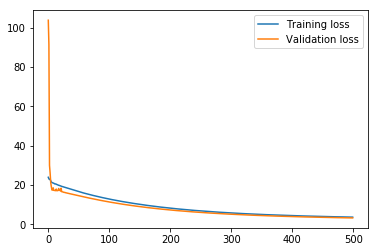

In [42]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [43]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(15, 100, 100, 3)
(15, 29, 29, 2)


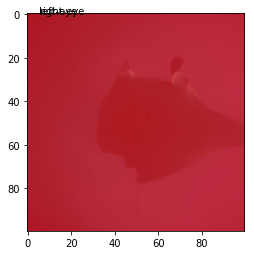

In [44]:
i=10

mfp.apply_heatmaps(mfp.denormalize(X_test[i]),pred[i]*5)

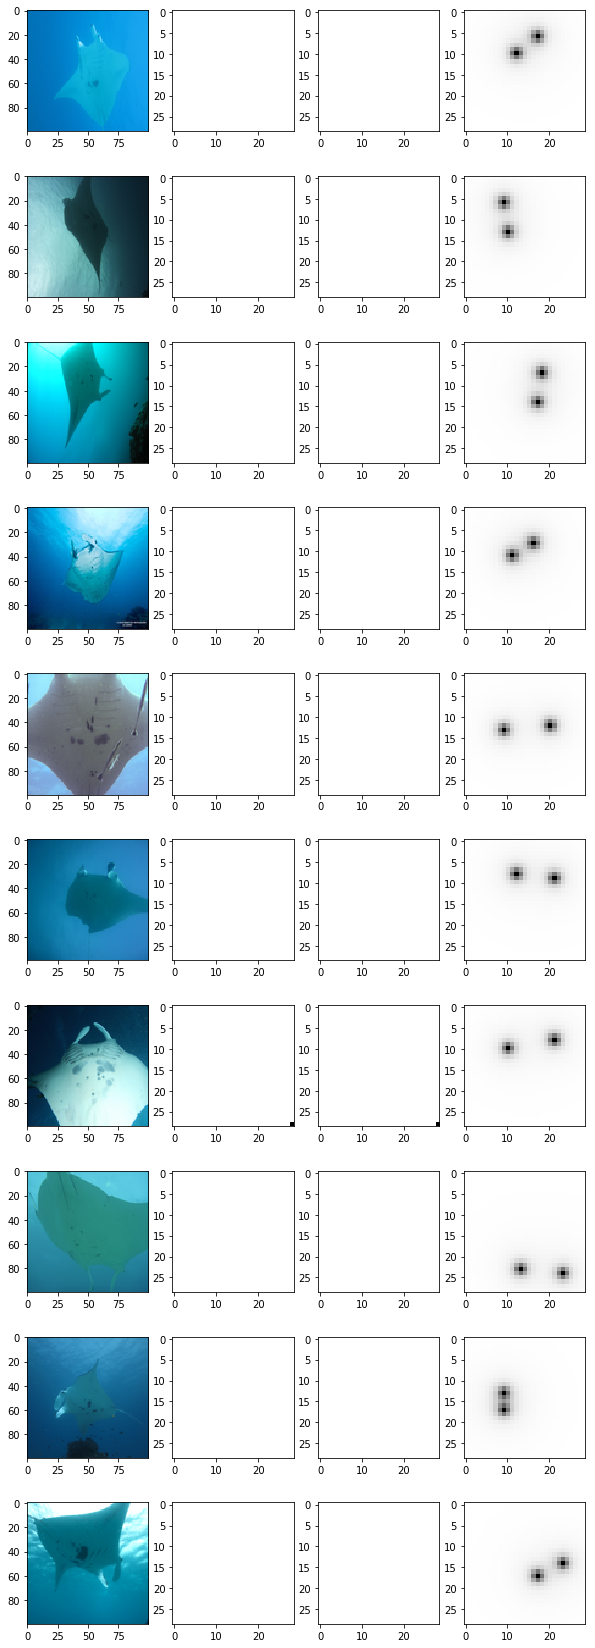

In [46]:
#### n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=4,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(pred[s][:,:,1],cmap='Greys')
    axes[i,3].imshow(y_test[s].sum(axis=2),cmap='Greys')
plt.show()

In [24]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling


SyntaxError: invalid syntax (<ipython-input-24-3a9fb3823701>, line 3)